# Download Dataset and Reformat

In [33]:
import math
import operator
from functools import reduce, partial
import numpy as nnp
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import kagglehub
from kagglehub import KaggleDatasetAdapter

from qiskit import QuantumCircuit
from qiskit.circuit.library import RXGate
from qiskit.quantum_info import Statevector

import pennylane as qml
from pennylane import numpy as np

import tensorflow as tf
from silence_tensorflow import silence_tensorflow

In [2]:
from src.layers import compressed_fc_op, custom_accuracy

In [3]:
SEED = 42
nnp.random.seed(SEED)
np.random.seed(SEED)
# torch.manual_seed(42)
tf.random.set_seed(SEED)

In [4]:
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "uciml/pima-indians-diabetes-database",
  "diabetes.csv"
)

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_38989/2019958825.py:1: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [5]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [6]:
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df["Outcome"] = (normalized_df["Outcome"] * 2) - 1  # Convert Outcome to -1 and 1
normalized_df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.743719,0.590164,0.353535,0.0,0.500745,0.234415,0.483333,1.0
1,0.058824,0.427136,0.540984,0.292929,0.0,0.396423,0.116567,0.166667,-1.0
2,0.470588,0.919598,0.524590,0.000000,0.0,0.347243,0.253629,0.183333,1.0


In [7]:
def QuantumEncode(x: list[list[float]]) -> list[list[float]]:
    """
    Quantum encoding function that encodes a list of lists into a quantum state.
    Each inner list is normalized and converted to a quantum state.
    """
    assert len(x) <= 16 and math.log2(len(x)).is_integer(), "len(x) must be a power of 2"
    s = len(x[0])
    extras = 1 if len(x) == 1 else int(math.log2(len(x)))


    qc = QuantumCircuit(s + 4)
    if len(x) > 1:
        qc.h(qc.qubits[s:s + 4])  # Apply Hadamard gates to the ancilla qubits
    
    for i, row in enumerate(x):
        for j, value in enumerate(row):
            if value != 0:
                gate = RXGate(value * math.pi).control(extras, ctrl_state=i)
                qc.append(gate, list(range(s, s + extras)) + [j])
    
    if len(x) > 1:       
        qc.h(qc.qubits[s:s + 4])
    
    sv = Statevector.from_instruction(qc).reverse_qargs()
    return sv.data.astype(nnp.complex64)
    

In [8]:
train, test = train_test_split(normalized_df, test_size=0.2, random_state=42)
train_data, test_data = train.drop(columns=["Outcome"]).values.tolist(), test.drop(columns=["Outcome"]).values.tolist()
train_data, test_data = [QuantumEncode([row]) for row in train_data], [QuantumEncode([row]) for row in test_data]
train_labels, test_labels = train["Outcome"].values.tolist(), test["Outcome"].values.tolist()

In [9]:
train_data, test_data  = map(
    lambda x: np.array(x, dtype=np.complex64, requires_grad=False),
    (train_data, test_data)
)
train_labels, test_labels = map(
    lambda x: np.array(x, dtype=np.float32, requires_grad=False),
    (train_labels, test_labels)
)

# Design Model and Quantum Circuit

In [10]:
dev = qml.device("default.qubit", wires=16)
wire_arr = nnp.arange(8+4)

In [11]:
@partial(qml.batch_input, argnum=0)
@qml.qnode(dev, interface='tf')
def qnode(inputs, 
          first_layer_weights,
          first_layer_bias,
          second_layer_weights,
          second_layer_bias,
          final_layer_weights,
          final_layer_bias):
    qml.StatePrep(inputs, wires=wire_arr.flatten(), validate_norm=False)
    
    compressed_fc_op(
          weight_params=first_layer_weights,
          b_params=first_layer_bias,
          x_wires=wire_arr[:8],
          b_wires=wire_arr[8:],
    )
    
    compressed_fc_op(
          weight_params=second_layer_weights,
          b_params=second_layer_bias,
          x_wires=wire_arr[:8],
          b_wires=wire_arr[8:],
    )
    
    compressed_fc_op(
          weight_params=final_layer_weights,
          b_params=final_layer_bias,
          x_wires=wire_arr[:8],
          b_wires=wire_arr[8:9],
    )
    
    return qml.expval(qml.PauliZ(0))

In [12]:
weight_shapes = {
    "first_layer_weights": (7, 8),
    "first_layer_bias": (8,),
    "second_layer_weights": (7, 8),
    "second_layer_bias": (4,),
    "final_layer_weights": (7, 8),
    "final_layer_bias": (1,)
}

qlayer =  qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=(1,))
{name: (reduce(operator.mul, x.shape), x.shape) for name, x in qlayer.qnode_weights.items()}, qlayer

/Users/addisonhanrattie/Documents/QuantumBattleship.nosync/.conda/lib/python3.10/site-packages/pennylane/qnn/keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(
2025-08-07 06:21:38.326016: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-08-07 06:21:38.326069: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-08-07 06:21:38.326078: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1754562098.326133  223965 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1754562098.326192  223965 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


({'first_layer_weights': (56, TensorShape([7, 8])),
  'first_layer_bias': (8, TensorShape([8])),
  'second_layer_weights': (56, TensorShape([7, 8])),
  'second_layer_bias': (4, TensorShape([4])),
  'final_layer_weights': (56, TensorShape([7, 8])),
  'final_layer_bias': (1, TensorShape([1]))},
 <Quantum Keras Layer: func=qnode>)

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2**12,)),
    qlayer,
])

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(opt, loss="MSE", metrics=[custom_accuracy])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_layer (KerasLayer)        │ (None, 1)              │           181 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181 (724.00 B)

 Trainable params: 181 (724.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
sample_output = model(train_data[:4])
print("Sample output shape:", sample_output.shape)
print("Sample output:", sample_output.numpy(), train_labels[:4])

Sample output shape: (4,)
Sample output: [ 0.03419696  0.00707103 -0.02032977 -0.00968069] [-1.  1. -1. -1.]


# Model Training

In [16]:
BATCH_SIZE = 8
remainder = train_data.shape[0] % BATCH_SIZE
if remainder != 0:
    train_data = train_data[:-remainder]
    train_labels = train_labels[:-remainder]
remainder2 = test_data.shape[0] % BATCH_SIZE
if remainder2 != 0:
    test_data = test_data[:-remainder2]
    test_labels = test_labels[:-remainder2]
train_data.shape, test_data.shape, train_labels.shape, test_labels.shape

((608, 4096), (152, 4096), (608,), (152,))

In [17]:
silence_tensorflow("ERROR")
fitting = model.fit(train_data, train_labels, epochs=3, batch_size=BATCH_SIZE, validation_data=(test_data, test_labels), verbose=1, shuffle=True)

Epoch 1/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - custom_accuracy: 0.6599 - loss: 0.9004 - val_custom_accuracy: 0.7039 - val_loss: 0.8151
Epoch 2/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - custom_accuracy: 0.7160 - loss: 0.7954 - val_custom_accuracy: 0.7368 - val_loss: 0.7957
Epoch 3/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - custom_accuracy: 0.7263 - loss: 0.7818 - val_custom_accuracy: 0.7632 - val_loss: 0.7909


In [28]:
predictions_proba = model.predict(test_data, batch_size=BATCH_SIZE)
predictions = nnp.where(predictions_proba > 0, 1, -1).flatten()
print(classification_report(test_labels, predictions, labels=[-1, 1], target_names=["Negative", "Positive"]))
print("Model accuracy:", custom_accuracy(test_labels, predictions).numpy())

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 431ms/step
              precision    recall  f1-score   support

    Negative       0.79      0.87      0.83        98
    Positive       0.70      0.57      0.63        54

    accuracy                           0.76       152
   macro avg       0.75      0.72      0.73       152
weighted avg       0.76      0.76      0.76       152

Model accuracy: 0.7631579


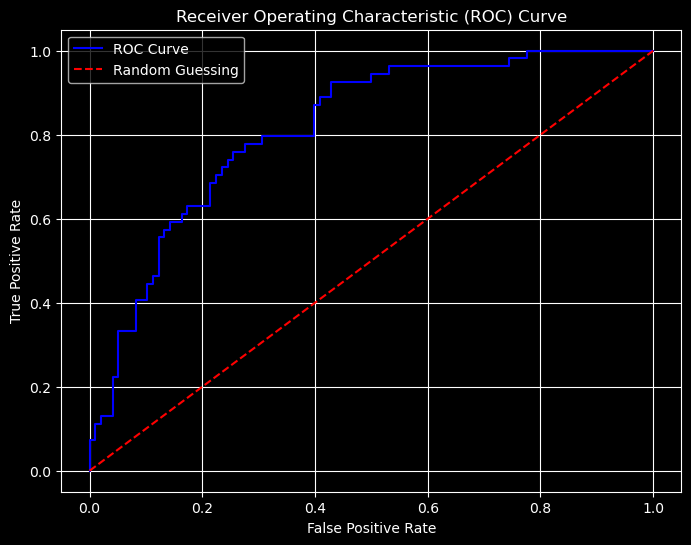

np.float64(0.8146258503401361)

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(test_labels, predictions_proba.flatten(), pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

roc_auc_score(test_labels, predictions_proba.flatten())